In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
# Imports
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import osmnx as ox
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
# quetzal-specific stuff
from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder
from quetzal.io.gtfs_reader import importer
from quetzal.model import stepmodel


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [3]:
training_folder = '../'
input_path = training_folder + 'input/'
model_path = training_folder + 'model/'
output_path = training_folder + 'outputs/'

In [4]:
show_plots = manual

## Load stepmodel

zones

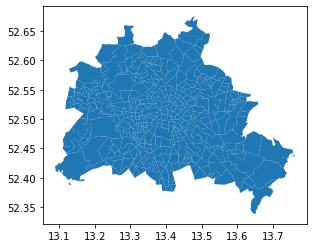

In [5]:
# Load the model with ber_zones
sm = stepmodel.read_json(model_path + 'zones')
if not type(sm.zones) == GeoDataFrame:
    sm.zones = GeoDataFrame(sm.zones, crs=sm.epsg)
if show_plots: sm.zones.plot()

## Road network

Build the road network graph from OpenStreetMap data and save it into GeoDataFrames

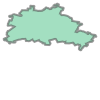

In [6]:
# To-Do think whether it might make sense to increase the buffer to cover Brandenburg
hull = unary_union([x.buffer(1e-3) for x in sm.zones['geometry']])
hull

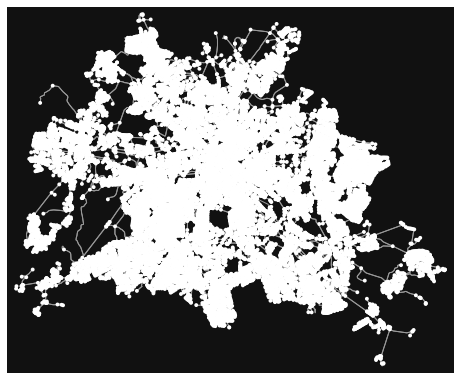

In [7]:
# Download roads from OpenStreetMap (online) and save it in a graph
# using the OSMNX library
drive = ox.graph_from_polygon(hull, network_type='drive')
# Plot it
if show_plots: ox.plot_graph(drive)

In [8]:
# Use OSMNX function to create GeoDataFrames from graph
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [9]:
# Let's have a look at the results
road_nodes.sample()

y          x  street_count  ref highway  \
osmid                                                        
247643719  52.567681  13.205158             1  NaN     NaN   

                            geometry  
osmid                                 
247643719  POINT (13.20516 52.56768)

In [10]:
road_links.sample()

osmid lanes                  name      highway  \
u        v        key                                                     
26570057 26570222 0    4361346     2  Frankenhauser Straße  residential   

                      maxspeed  oneway reversed  length  \
u        v        key                                     
26570057 26570222 0         30   False     True  178.64   

                                                                geometry  \
u        v        key                                                      
26570057 26570222 0    LINESTRING (13.35200 52.41851, 13.34968 52.41774)   

                      width  ref bridge tunnel junction access area service  \
u        v        key                                                         
26570057 26570222 0     NaN  NaN    NaN    NaN      NaN    NaN  NaN     NaN   

                      est_width  
u        v        key            
26570057 26570222 0         NaN

In [11]:
# Check if the columns you want to use later are in the columns above.
# If they appear as index names (printed bold), use the reset_index()
# function to create a new Data

In [12]:
road_nodes = road_nodes.reset_index()
road_links = road_links.reset_index()

In [13]:
# Rename columns and make them type string for later operations
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)

In [14]:
# Create a cleaner object and run cleaning functions on it
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='from', 
    b='to'
)

In [15]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
#oc.clean_geometries() # Doesn't work, but let's hope we don't need it
oc.fix_nodeset_consistency()

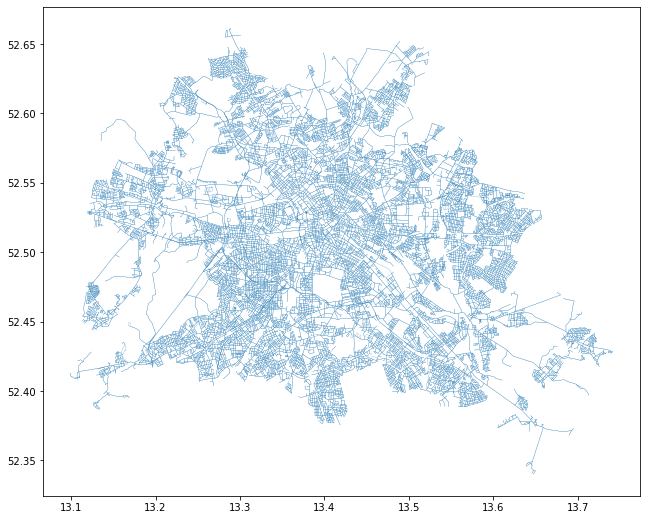

In [16]:
if show_plots: road_links.plot(figsize=(16,9), linewidth=0.2)

Our road network is now saved in `oc.nodes` and `oc.links`

## Public Transport

For PT, we need to convert GTFS feeds into links and nodes GeoDataFrames

In [38]:
# Load the GTFS feed
full_feed = importer.GtfsImporter(path=input_path+'public_transport/2024-02-19_GTFS.zip', dist_units='m')
# downloaded from http://vbb.de/vbbgtfs

In [39]:
# Restrict the feed to a given date in order to analyse a
# typical work day and not the whole week
feed_r = full_feed.restrict(
    dates=['20240215','20240215'] # the dates must be within the feed start and end dates
)

In [40]:
# We can also restrict it to hours
time_range = ['04:00:00', '22:00:00']
feed_r = feed_r.restrict(time_range=time_range)

In [41]:
# And we can restrict it spacially if we write a suitable function
def spatial_restrict(feed, polygon, how='inner'):
    f = feed.copy()
    stops = f.stops.copy()
    stops['geometry'] = stops.apply(
        lambda r: Point([r['stop_lon'], r['stop_lat']]),
        axis=1
    )
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    f.stops = f.stops.loc[stops['included'] == True]

    # relations
    f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
    relevant_trips = (f.stop_times['trip_id'])
    f = f.restrict(trip_ids=relevant_trips)
    if how == 'inner':
        return f
    else:
        return feed.restrict(trip_ids=relevant_trips)

In [42]:
# Give the hourly restricted feed to the spatial restriction
feed_s = spatial_restrict(feed_r, polygon=hull, how='inner')

In [50]:
# GTFS feeds are very complex. Have a look at Wikipedia for its structure
# We need to perform some operations in order to transform it into a graph
feed_s.calendar_dates.drop_duplicates(inplace=True)
feed_s.group_services()
feed_s.build_stop_clusters(distance_threshold=300) # clusterize stops
feed_s.build_patterns(on='cluster_id') # use on='stop_id' if you didn't build clusters

In [52]:
feed_frequencies = feed_s.convert_to_frequencies(time_range=time_range)

In [53]:
# We can build links and nodes now from the frequency graph
feed_frequencies.build_links_and_nodes(time_expanded=True)
feed_frequencies.build_geometries(use_utm=False)

export geometries in epsg: 32633


In [54]:
feed_frequencies.links.sample()

index                      a      trip_id  link_sequence  \
12295  12049  de:11000:900152505::1  17368_700_2             32   

       departure_time  pickup_type                      b  arrival_time  \
12295         36900.0            0  de:11000:900152504::1       36960.0   

       drop_off_type  time  ... wheelchair_accessible bikes_allowed agency_id  \
12295              0  60.0  ...                     1             2       796   

      route_short_name route_long_name  route_type route_color  \
12295              256             NaN         700         NaN   

      route_text_color  route_desc  \
12295              NaN         NaN   

                                                geometry  
12295  LINESTRING (13.52978 52.58113, 13.53096 52.58405)  

[1 rows x 28 columns]

In [55]:
feed_frequencies.nodes.sample(1)

stop_id stop_code                           stop_name  \
18113  de:11000:900175008::2       NaN  Chemnitzer Str./Jägerstr. (Berlin)   

                                       stop_desc  location_type  \
18113  Bushalt Chemnitzer Straße ht. Jägerstraße              0   

      parent_station  wheelchair_boarding platform_code  \
18113            NaN                    0           NaN   

                                       zone_id  level_id  cluster_id  \
18113  5656_Chemnitzer_Str./Jägerstr._(Berlin)       4.0         479   

                        geometry  
18113  POINT (13.57392 52.48569)

In [60]:
# Make stop_id the unique index of nodes
feed_frequencies.nodes.set_index('stop_id', inplace=True)

In [61]:
feed_frequencies.links['route_type'].unique()

array([ 109,  900,  700,  100, 1000,  400,    3,    2], dtype=int64)

In [62]:
# Rename the route types
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',
    4:'ferry', 5:'cable_car', 6:'gondola', 7:'funicular'}
#Additional route types used in VBB Data:
ex_mapping = {100:'rail', 109:'rail', 400:'subway', 700:'bus', 900:'tram', 1000:'ferry'}
mapping.update(ex_mapping)

feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

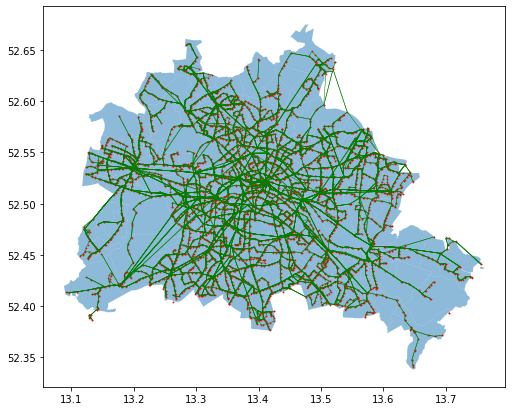

In [63]:
if show_plots:
    # Plot the results using matplotlib notation
    ax = sm.zones.plot(alpha=0.5, figsize=[17, 7])
    ax = feed_frequencies.links.plot(linewidth=0.5, color='green', ax=ax)
    plot= feed_frequencies.nodes.plot(markersize=0.5, color='red', ax=ax)

## Create the transport model

We have the network DataFrames and need to put them into a model now, to be able to run quetzal functions on it, that go beyond the scope of only one DataFrame

In [64]:
# Add road network
sm.road_links = oc.links[['a', 'b', 'length', 'geometry', 'highway', 'maxspeed']]
sm.road_nodes = oc.nodes[['geometry']]

In [66]:
# Assign PT network to it with the columns we need
sm.links = feed_frequencies.links[['trip_id', 'a', 'b', 'link_sequence', 'time',# 'headway',
                                   'route_id', 'agency_id', 'route_type', 'geometry']]
sm.nodes = feed_frequencies.nodes[['geometry', 'stop_name', 'location_type']]

## Check integrity

Run quetzals integrity check functions to see if the networks are alright

In [67]:
# check and fix name collision in the indicies
sm.integrity_fix_collision()

can not add prefixes on table:  footpaths


In [68]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 28287it [00:06, 4530.35it/s]
reversed: 28287it [00:06, 4538.12it/s]
28204it [00:06, 4245.53it/s]


In [69]:
# Fix PT
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()

dropped circular lines: ['5241_700_2', '17318_700_4', '17372_700_0', '24053_100_4', '17534_700_1', '23984_700_2', '5238_700_2', '17385_700_1', '19058_100_5', '17387_700_2', '10163_109_3', '17290_700_5', '17361_700_1', '24045_100_3', '10157_109_4', '16859_700_2', '10158_109_4', '17328_700_2', '17534_700_0', '17538_700_1', '17346_700_1', '10276_109_3', '23945_100_4', '10141_109_1', '17295_700_0', '17346_700_0', '17347_700_0', '17413_700_0', '17304_700_5', '10224_109_2', '17394_700_2', '10142_109_1', '19019_700_0', '21649_109_2', '24055_100_2', '17329_700_0', '24054_100_2', '17452_900_8', '10223_109_2', '17459_900_8', '17329_700_1', '10166_109_3', '17463_900_8', '17345_700_1', '17292_700_2', '17292_700_0', '17292_700_1', '17375_700_1', '23945_100_3', '17348_700_2', '17394_700_3', '17295_700_3', '23946_100_3', '17324_900_8', '17520_700_3', '17520_700_2', '10159_109_3', '10165_109_3', '17531_700_0', '17382_700_1', '10162_109_3', '24864_109_1', '23984_700_3', '17453_700_3', '17538_700_2', '1

In [70]:
# Test
sm.integrity_test_all(errors='raise')

passed: integrity_test_circular_lines
passed: integrity_test_collision


28204it [00:01, 15537.41it/s]


passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


28204it [00:07, 3843.27it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


## Network connectors

We have road and PT links and nodes. Now we need to connect them for people to be able to switch and enter as they want

In [71]:
# Create a footpaths table
sm.preparation_footpaths(max_length=1000, n_clusters=int(len(sm.zones)*2))
len(sm.footpaths)

63026

In [72]:
# store old zone geometry
zones = sm.zones[['geometry']].copy()
# change zone geoemtry to circle around pop centroid, to have the following step run with respect to this centroid
sm.zones['geometry'] = [(Point(lon,lat) if lon>0 and lat>0 else g.centroid).buffer(1e-6) for lon,lat,g in zip(sm.zones['popCentroidLon'].values, sm.zones['popCentroidLat'].values, sm.zones['geometry'].values)]

# Create access and egress links (ntlegs)
threshold = 200
sm.preparation_ntlegs(
    short_leg_speed=3, # km/h
    long_leg_speed=7, # km/h
    threshold=threshold, # m
    zone_to_transit=True, # zone centroid - PT connectors
    zone_to_road=True, # zone centroid - road connectors
    n_ntlegs=5 # number of connectors
)

# restore old geometry
sm.zones['geometry'] = zones['geometry']

In [73]:
# This is how the new tables look like
# Re-index them too
sm.zone_to_transit.index = ['ztt_'+str(i) for i in sm.zone_to_transit.index]
sm.zone_to_transit.sample(1)

a                           b  rank    distance  \
ztt_643  zone_05030730  node_de:11000:900034158::2     1  238.988059   

                                                  geometry direction  \
ztt_643  LINESTRING (13.227539226219985 52.551229263930...    access   

         speed_factor  short_leg_speed  long_leg_speed   speed        time  \
ztt_643      1.093133                3               7  3.2794  262.351979   

          walk_time  
ztt_643  262.351979

In [ ]:
sm.zone_to_road.index = ['ztr_'+str(i) for i in sm.zone_to_road.index]
sm.road_to_transit.index = ['rtt_'+str(i) for i in sm.road_to_transit.index]

# Networkcaster

## Rail

In [76]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['subway', 'rail', 'ferry'])]
#rail.preparation_cast_network(dumb_cast=True)

## Road

In [77]:
road = sm.copy()
road.links = road.links.loc[road.links['route_type'].isin(['bus', 'tram'])]
road.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

17314_700_0: 100%|███████████████████████████████████████████████████████████████████| 891/891 [02:01<00:00,  7.35it/s]


## both road and rail

In [78]:
pt = road
pt.links = pd.concat([road.links, rail.links])
pt.analysis_lines(line_columns='all')

# monitoring

In [79]:
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile5/tile21/tile21.png'
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile21/tile21/tile5.png'
def plot_networkcaster(raw, processed, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax = plt.subplots(2, 2,  figsize=figsize, tight_layout=True)
    
    # print(0)
    buffer = raw.copy()
    # buffer_width = max(raw.zones['geometry'].apply(lambda g: max(abs(g.bounds[0]-g.bounds[2]), abs(g.bounds[1]-g.bounds[3]))))/2
    # buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(buffer_width))
    
    # print(1)
    # raw.road_nodes.plot(markersize=0.3, color='black', ax=ax.flat[0])
    raw.road_links.plot(linewidth=0.3, color='green', ax=ax.flat[0])
    ax.flat[0].set_title("Road network")
    
    # print(2)
    raw.links.plot(ax=ax.flat[1], color='blue', linewidth=0.5)
    gpd.GeoSeries(raw.nodes.geometry, crs=sm.epsg).plot(ax=ax.flat[1], color='black', markersize=10)
    gpd.GeoSeries(raw.disaggregated_nodes.geometry, crs=sm.epsg).plot(ax=ax.flat[1], color='pink', markersize=2)
    # if interested one could add disaggregated_nodes and connect them to center node.
    ax.flat[1].set_title("GTFS")

    # print(3)
    raw.road_links.plot(color='green', linewidth=0.5, ax=ax.flat[2])
    raw.links.plot(ax=ax.flat[2], color='blue', linewidth=0.2)
    ax.flat[2].set_title("raw GTFS & road network")

    # print(4)
    # gpd.GeoSeries(processed.road_links['geometry'], crs=sm.epsg).plot(ax=ax.flat[3], color='green', linewidth=0.5)
    # gpd.GeoSeries(processed.links['geometry'], crs=sm.epsg).plot(ax=ax.flat[3], color='blue', linewidth=0.5)
    processed.road_links.plot(ax=ax.flat[3], color='green', linewidth=0.5)
    processed.links.plot(ax=ax.flat[3], color='blue', linewidth=0.5)
    ax.flat[3].set_title("Processed GTFS & Road Network")
    
    # print(5)
    for _ax in ax.flat:
        _ax.set_xlim(buffer.zones['geometry'].total_bounds[0], buffer.zones['geometry'].total_bounds[2])
        _ax.set_ylim(buffer.zones['geometry'].total_bounds[1], buffer.zones['geometry'].total_bounds[3])

    return fig

In [80]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in pt.__dict__.keys() if type(pt.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in pt.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    pt.__dict__[key] = gpd.GeoDataFrame(pt.__dict__[key], crs=sm.epsg)
broken_gdf_keys = [key for key in pt.__dict__.keys() if type(pt.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in pt.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("Broken GeoDataFrames:",broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['footpaths', 'networkcaster_neighbors', 'networkcaster_road_access', 'road_to_transit', 'zone_to_transit', 'zone_to_road']
Successfully fixed.


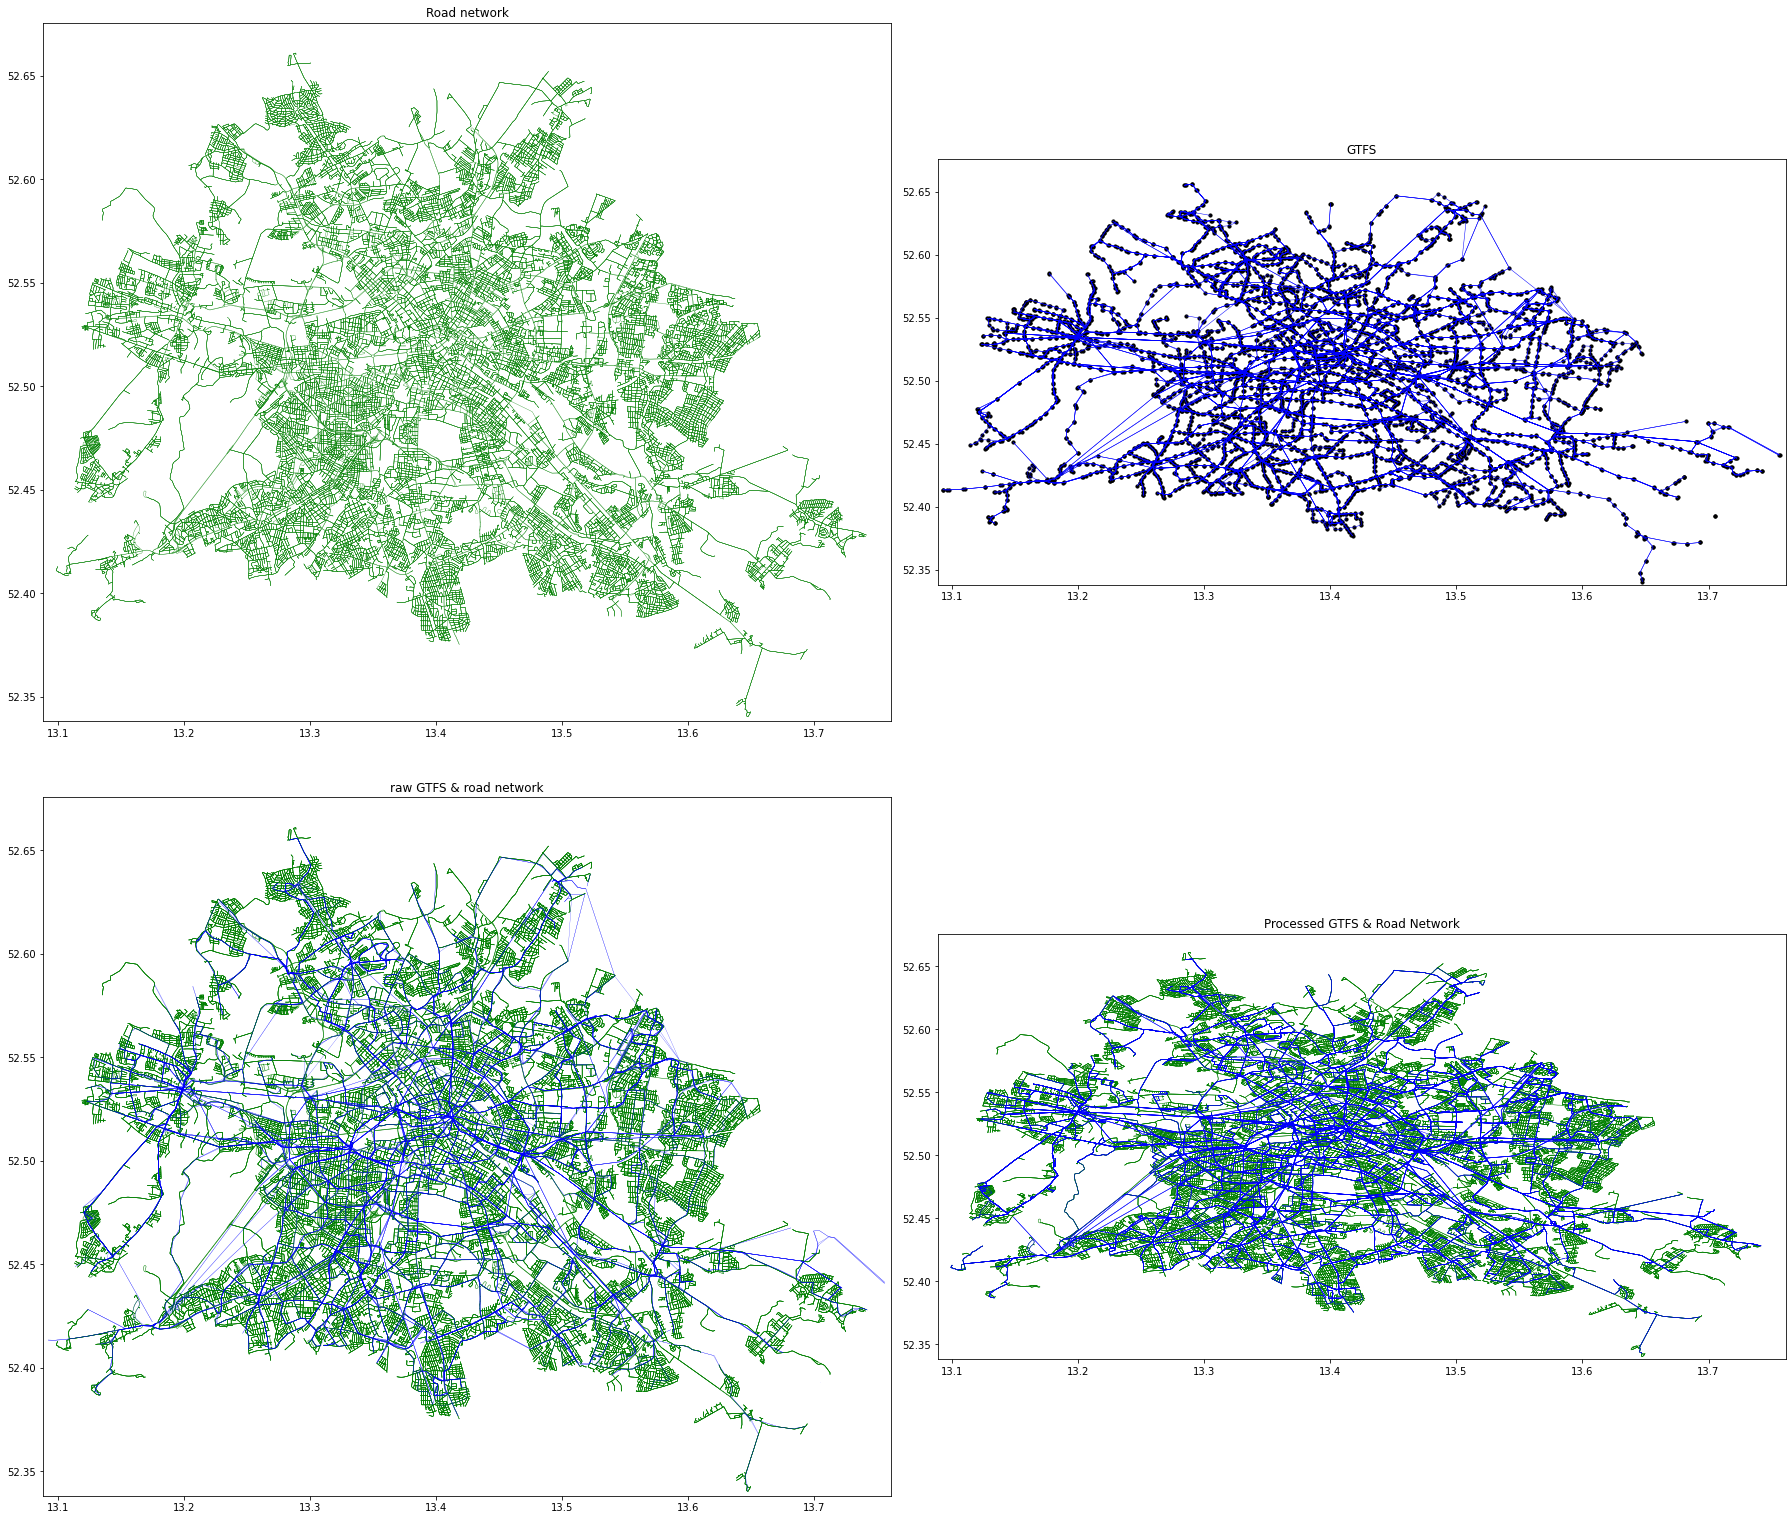

In [81]:
if show_plots:
    fig = plot_networkcaster(raw=sm, processed=pt)
    plt.savefig(output_path+'plots/network_casting.png', dpi=300)

In [82]:
sm = pt

## Match traffic counts data to road network
- logic: create buffers around road_network and obtain intersection between the network polygons to match road links from validation data to road links from network
- for an even more accurate matching one could use the non-simplified links.

link_id               elem_nr         vnp         nnp  vst  \
5011  46620026_T0096260  46620026_46610007.02  46620026.0  46610007.0  0.0   

       bst vricht  ebene str_typ strklasse1 strklasse strklasse2  \
5011  78.0      B    0.0       S         II         B       STRA   

            str_name  bezirk          stadtteil  dtvw_kfz  dtvw_lkw  \
5011  Dietzgenstraße  Pankow  Niederschönhausen   15000.0     700.0   

                                               geometry  
5011  LINESTRING (13.40345 52.58296, 13.40369 52.582...

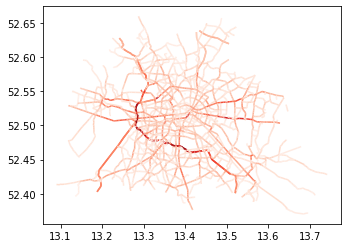

In [83]:
traffic_validation = gpd.read_file(input_path + "traffic_validation/Verkehrsmengen.shp")
traffic_validation.to_crs(epsg=sm.epsg, inplace=True)
traffic_validation.plot(cmap="Reds", column='dtvw_kfz')
traffic_validation.sample(1)

In [84]:
def gridSearchIntersections (
        intersectionOf:GeoSeries, 
        intersectionWith:GeoSeries, 
        gridDimensions:tuple=(1,1), 
        outerBox:tuple=False,
        calc_margin_on:GeoSeries=None,
        plot:bool=True
        ) -> list:
    """
    Function that speeds up the search for an array of polygon within a GeoDataFrame
    returns GeoDataFrame with original geometry replaced with intersections geometry
    
    outerBox = (min_x, min_y, max_x, max_y)
    insideBufferInMeters should be at least circle radius around if looking for intersection of circles with something
    """
    if plot: print('Generate plots.')
    print('set up margins for grid search')
    t = datetime.now()

    if not type(outerBox) == tuple:
        outerBox = intersectionWith.total_bounds
    outerBoxPoly = Polygon([(outerBox[0], outerBox[1]), (outerBox[2], outerBox[1]), (outerBox[2], outerBox[3]), (outerBox[0], outerBox[3])])
    
    # continue here maybe use intersectionWith
    if not type(calc_margin_on) in (GeoSeries, GeoDataFrame):
        calc_margin_on = intersectionOf
    if not type(calc_margin_on) == GeoDataFrame:
        calc_margin_on = GeoDataFrame(geometry=calc_margin_on, crs=calc_margin_on.crs)
    
    # prepare margin
    m_prep = [[abs(t[0]-t[1]) for t in x.xy] for x in calc_margin_on['geometry']]
    calc_margin_on['x_ext'] = [x[0] for x in m_prep]
    calc_margin_on['y_ext'] = [x[1] for x in m_prep]
    
    dim_x, dim_y = gridDimensions[0], gridDimensions[1]
    # stepsize_x, stepsize_y = (outerBox[2]-outerBox[0]-2*margin_x)/dim_x,  (outerBox[3]-outerBox[1]-2*margin_y)/dim_y
    stepsize_x, stepsize_y = (outerBox[2]-outerBox[0])/dim_x,  (outerBox[3]-outerBox[1])/dim_y

    # xsteps = [margin_x+outerBox[0]+stepsize_x*(n) for n in range(dim_x+1)]
    # ysteps = [margin_y+outerBox[1]+stepsize_y*(n) for n in range(dim_y+1)]
    xsteps = [outerBox[0]+stepsize_x*(n) for n in range(dim_x+1)]
    ysteps = [outerBox[1]+stepsize_y*(n) for n in range(dim_y+1)]
    

    print('time spent to set up correct margins', datetime.now()-t)
    print("set up grid cells")

    grid = [[] for i in range(dim_x)]
    gridPolys = []
    t = datetime.now()
    for i in range(dim_x):
        if (100 * i / dim_x) % 20 == 0 and i > 0:
            print(round(100*i/ dim_x), "% Time remaining:", (datetime.now()-t)*(1- i/dim_x)/(i/ dim_x), 
            "% Time remaining:", (datetime.now()-t)*(1- i/dim_x)/(i/ dim_x),
            'Time elapsed:', datetime.now()-t)
        
        gridCol_of = calc_margin_on.cx[xsteps[i] : xsteps[i+1], : ]
        margin_x = gridCol_of['x_ext'].max() if len(gridCol_of)>0 else 0.0

        gridCol = intersectionWith.cx[xsteps[i]-margin_x : xsteps[i+1]+margin_x, : ]
        
        if len(gridCol)==0:
            grid[i].extend([gridCol for j in range(dim_y)])
            gridPolys.extend([Polygon([]) for j in range(dim_y)])
            continue

        for j in range(dim_y):

            gridCell_of = gridCol_of.cx[ : , ysteps[j] : ysteps[j+1]]
            margin_y = gridCell_of['y_ext'].max() if len(gridCell_of)>0 else 0.0
            gridCell = gridCol.cx[ : , ysteps[j]-margin_y : ysteps[j+1]+margin_y]
            grid[i].append(gridCell) 
            
            if plot:
                gridPolys.append(Polygon([\
                    (xsteps[i]-margin_x, ysteps[j]-margin_y), \
                    (xsteps[i]-margin_x, ysteps[j+1]+margin_y), \
                    (xsteps[i+1]+margin_x, ysteps[j+1]+margin_y), \
                    (xsteps[i+1]+margin_x, ysteps[j]-margin_y)\
                ]))
    
    print(datetime.now() - t, "time spent to set up grid cells",gridDimensions, '=',gridDimensions[0]*gridDimensions[1], '')

    t = datetime.now()

    intersection_df = intersectionOf.copy()
    intersections = []

    time_lookup = datetime.now()-datetime.now()
    time_intersection = datetime.now()-datetime.now()

    print('start creating intersections')
    len_io = len(intersectionOf)
    for n, geom in zip(range(len_io), list(intersectionOf)):
        if (n*100 / len_io) % 2 > ((n+1)*100 / len_io) % 2 and n > 0:
            print(round(100*n/ len_io), 
            "% Time remaining:", 
            (datetime.now()-t)*(1- n/len_io)/(n/ len_io),
            'Time elapsed:', datetime.now()-t,
            'total look_up time:', time_lookup,
            'total intersection time:', time_intersection)
        
        # geom = intersectionOf.iloc[n]
        t_ = datetime.now()
        centroidCoords = geom.centroid.coords[0]
        try:
            i = next(n for n,x in enumerate(xsteps) if x>centroidCoords[0]) -1
        except:
            i = -1
        try:
            j = next(n for n,y in enumerate(ysteps) if y>centroidCoords[1]) -1
        except:
            j = -1
        time_lookup += datetime.now()- t_

        t_ = datetime.now()
        intersection = [] if -1 in (i,j) and not geom.intersects(outerBoxPoly) else [(n,g) for n,g in zip(grid[i][j].index, grid[i][j].intersection(geom)) if not g.is_empty]
        intersection_areas = [(n, x.area) for n,x in intersection]
        intersection_union_area = unary_union([x for n,x in intersection]).area
        time_intersection += datetime.now()- t_
        intersections.append((intersection_areas, intersection_union_area))

        
    print(datetime.now() - t, "time spent to create intersection",len(intersectionOf),
            'total look_up time:', time_lookup,
            'total intersection time:', time_intersection)

    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
        intersectionOf.plot(ax=ax, color="red", alpha=.3)
        intersectionWith.plot(ax=ax, color="blue", alpha=.3)
        GeoSeries([outerBoxPoly], crs=4326).plot(ax=ax, color="none", edgecolor="black", linewidth=2)
        GeoSeries(gridPolys, crs=4326).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=.5)
    
    return intersections    

### choose buffer parameter
- the coice matters! 
- be as precise as possible (its better to have fewer validation data, than wrong validation data!)


#### Match validation data to sm.road_links

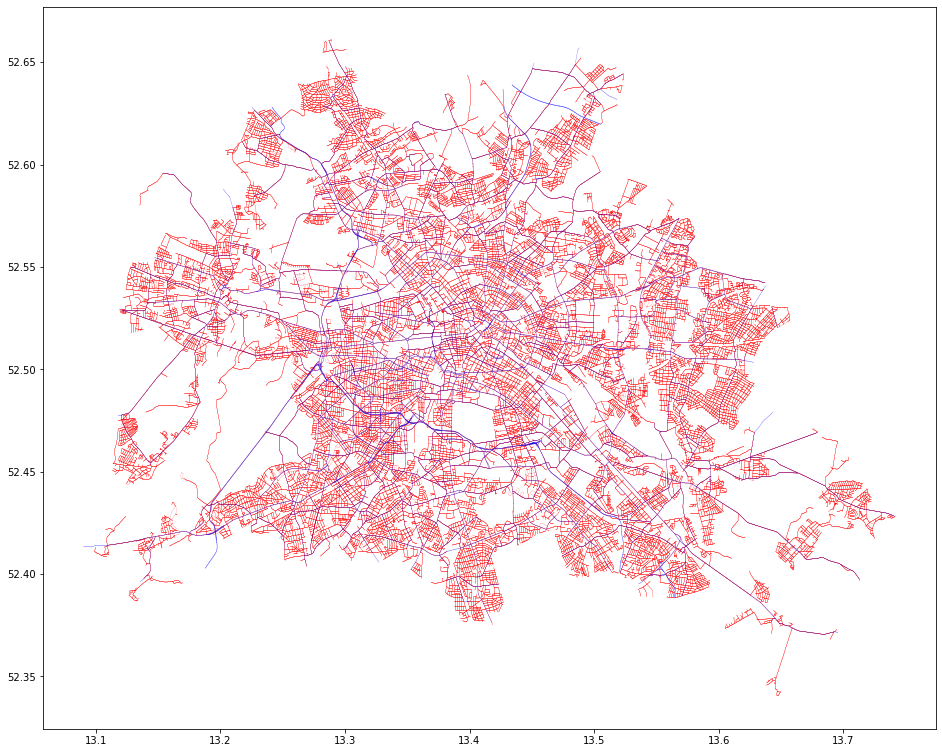

In [85]:
# define the width of each polygon. the choice of this parameter matters! b
validation_buffer = 0.0001
# for each link in road network compute its validation traffic data by:
network_buff = sm.road_links.buffer(validation_buffer*.5)
validation_buff = traffic_validation.buffer(validation_buffer)

if show_plots:
    fig, ax = plt.subplots(figsize = (16,16))
    network_buff.plot(ax=ax, color="red")
    validation_buff.plot(ax=ax, color="blue", alpha=0.75)

In [86]:
# for each link in road network with buffer calculate retrieve its intersection with validation data gdf
# its best to make the grid very fine so that grid creation and intersection time are balanced
# function still take over 10 Minutes.
road_links_validation_intersections = \
    gridSearchIntersections(
        intersectionOf=network_buff, 
        intersectionWith=validation_buff, 
        gridDimensions=(70,70), 
        calc_margin_on=sm.road_links['geometry'],
        plot=False
        )


set up margins for grid search
time spent to set up correct margins 0:00:09.228718
set up grid cells
20 % Time remaining: 0:00:13.991400 % Time remaining: 0:00:13.991400 Time elapsed: 0:00:03.497850
40 % Time remaining: 0:00:13.428250 % Time remaining: 0:00:13.428250 Time elapsed: 0:00:08.952166
60 % Time remaining: 0:00:09.864780 % Time remaining: 0:00:09.864780 Time elapsed: 0:00:14.797170
80 % Time remaining: 0:00:05.013920 % Time remaining: 0:00:05.013920 Time elapsed: 0:00:20.055680
0:00:23.453895 time spent to set up grid cells (70, 70) = 4900 
start creating intersections
2 % Time remaining: 0:07:36.487599 Time elapsed: 0:00:09.313687 total look_up time: 0:00:00.151852 total intersection time: 0:00:06.032022
4 % Time remaining: 0:06:14.257171 Time elapsed: 0:00:15.592969 total look_up time: 0:00:00.338911 total intersection time: 0:00:12.112946
6 % Time remaining: 0:05:40.457543 Time elapsed: 0:00:21.731219 total look_up time: 0:00:00.466793 total intersection time: 0:00:18.1098

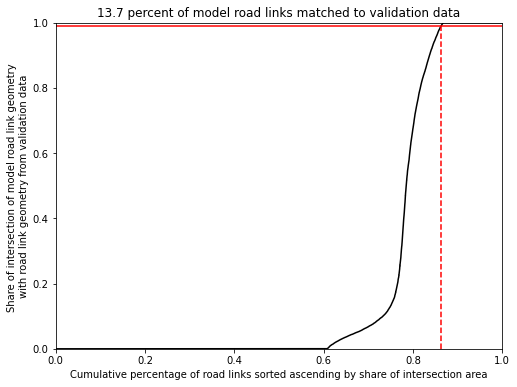

In [87]:
# now weight the intersection by area / divide by total intersection number and multiply it with respective validation data point
# make sure that not every road that just touches a road with validation data at a crossing is treated as if it has validation data
# by adding a threshold of how large the  be at least
total_intersection_areas = [sum([y for n, y in x[0]]) for x in road_links_validation_intersections]
tvd = list(traffic_validation['dtvw_kfz'])

sm.road_links['validation_load'] = \
    [sum([x/t*tvd[n] for n,x in xsections]) \
    if xarea > (nb.area * 0) else 0 \
    for (xsections, xarea),t,nb in zip(road_links_validation_intersections, total_intersection_areas, network_buff)] 

sm.road_links['validation_share'] = [xarea/nb.area for (xsections, xarea), nb in zip(road_links_validation_intersections, network_buff)] 

threshold = 0.99
sm.road_links['validation_threshold'] = sm.road_links['validation_share'] > threshold

share = sum(sm.road_links['validation_threshold'])/len(sm.road_links)

fig, ax = plt.subplots(ncols=1, figsize = (8,6))
ax.plot([x/len(sm.road_links) for x in range(len(sm.road_links))], sorted([(x[1]/nb.area) for x,t,nb in zip(road_links_validation_intersections, total_intersection_areas, network_buff)]), 'k')
ax.hlines(threshold, 0, 1, linestyles ="solid", colors ="red")
ax.vlines(1-share, 0, threshold, linestyles ="dashed", colors ="red")
ax.set_title(str(round(share*100,1)) + ' percent of model road links matched to validation data')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_ylabel('Share of intersection of model road link geometry \nwith road link geometry from validation data')
ax.set_xlabel('Cumulative percentage of road links sorted ascending by share of intersection area')

plt.savefig(output_path+'plots/road_validation_match_stats.png', dpi=300)

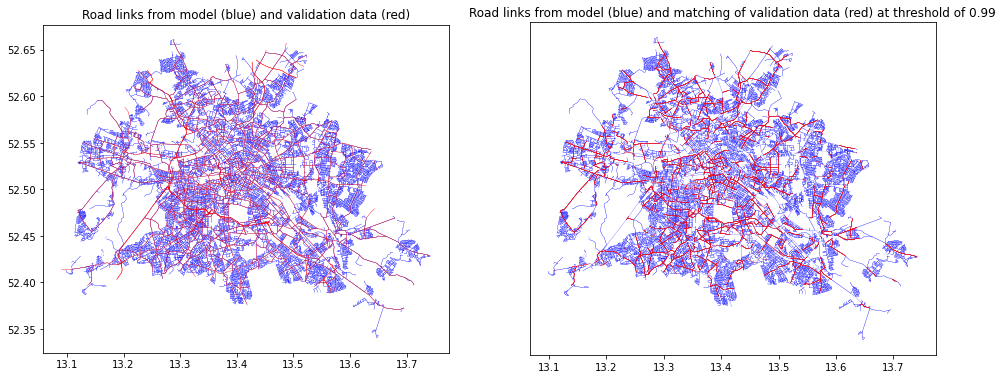

In [88]:
if show_plots:
    fig, ax = plt.subplots(ncols=2, figsize = (16,10))

    sm.road_links.plot(ax=ax.flat[0], color="blue", alpha=1, linewidth=.1)
    traffic_validation.plot(ax=ax.flat[0], color="red", linewidth=0.4)
    # network_buff.plot(ax=ax.flat[0], color="blue", alpha=.5, linewidth=0.5)
    # validation_buff.plot(ax=ax.flat[0], color="red", linewidth=0.5)
    ax.flat[0].set_title('Road links from model (blue) and validation data (red)')

    sm.road_links.plot(ax=ax.flat[1], color="blue", alpha=1, linewidth=.1)
    sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.3)
    # network_buff.plot(ax=ax.flat[1], color="blue", alpha=.5, linewidth=0.5)
    # network_buff[sm.road_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.5)
    ax.flat[1].set_title('Road links from model (blue) and matching of validation data (red) at threshold of '+str(threshold))
    ax.flat[1].axes.get_yaxis().set_visible(False)

    # sm.road_links.plot(ax=ax.flat[2], color="blue", alpha=1, linewidth=.1)
    # traffic_validation.plot(ax=ax.flat[2], color="black", linewidth=0.4)
    # sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[2], color="red", linewidth=0.3)

    plt.savefig(output_path+'plots/road_validation_match'+'_dpi300.png', dpi=300)
    plt.savefig(output_path+'plots/road_validation_match'+'_dpi600.png', dpi=600)

## Save the model

We have a complete network with connectors. Now save it.

quetzal provides two functions. One is the to_zip (and read_zip for loading again), which is very fast, but the file format is hdf5, which is not compatible with other programs.

The other option is to_json (and read_json), which saves tables as GeoJSON format. This is great to look at them in GIS software like QGIS, but it is slower for larger models.

Both functions take the location string as a first argument and optionally the only_attributes argument, where you can pass a list of table names that should be saved. All others are discarded.

In [89]:
# We can drastically reduce the disc space needed for this table by
# reducing the complexity of LineString geometries.
# For our purpose it is enough to have the start and end point of a link.
# Let's write a function
def simplify_link(g):
    l = list(g.coords)
    return LineString([l[0], l[-1]])
# Apply the function to all our links
#sm.road_links['geometry'] = sm.road_links['geometry'].apply(simplify_link)

In [94]:
# Remove useless information
to_drop = ['rank', 'speed_factor', 'long_leg_speed', 'short_leg_speed', 'walk_time', 'voronoi']
for df in [sm.zone_to_road, sm.zone_to_transit, sm.road_to_transit, sm.footpaths]:
    df.drop(columns=to_drop, errors='ignore', inplace=True)

In [95]:
sm.to_json(model_path + 'network', only_attributes=[
    'zones', 'centroids', 'footpaths', 'links', 'nodes', 'road_links', 'road_nodes', 
    'zone_to_road', 'zone_to_transit', 'road_to_transit'
])

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 40/40 [01:13<00:00,  1.83s/it]
